In [2]:
import config_dodo
from utilities import read_pickle, write_pickle
import config
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import umap
import hdbscan
import seaborn as sns

sns.set_context("paper", font_scale=1.5)
plt.rc("figure", figsize=(10, 10))
plt.rc("axes", labelsize=16, labelcolor="k")
plt.rc("xtick", labelsize=14, color="k")
plt.rc("ytick", labelsize=14, color="k")
plt.rc("legend", fontsize=14)
plt.rc("legend", title_fontsize=14)
plt.rc("savefig", bbox="tight")

dep_pickle_paths = {
    "ang": [],
    "wav": [],
    "stat": config_dodo.ANG_PATH / "stat_global.pickle",
    "pca": config_dodo.WAV_PATH / "pca_fit_wav.pickle",
    "emb_ang": config_dodo.EMB_PATH / "emb_ang_sample.pickle",
    "emb_wav": config_dodo.EMB_PATH / "emb_wav_sample.pickle",
}
target_pickle_paths = {
    "out_ang": [],
    "out_wav": [],
}
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    dep_pickle_paths["ang"].append(config_dodo.ANG_PATH / f"ang_{pickle_end}")
    dep_pickle_paths["wav"].append(config_dodo.WAV_PATH / f"wav_{pickle_end}")
    target_pickle_paths["out_ang"].append(
        config_dodo.OUT_PATH / f"out_ang_{pickle_end}"
    )
    target_pickle_paths["out_wav"].append(
        config_dodo.OUT_PATH / f"out_wav_{pickle_end}"
    )

emb_angs = read_pickle(dep_pickle_paths["emb_ang"])
out_angs = emb_angs.embedding_

emb_wavs = read_pickle(dep_pickle_paths["emb_wav"])
out_wavs = emb_wavs.embedding_

Fri Sep 10 15:32:27 2021 Building and compiling search function
Fri Sep 10 15:32:37 2021 Building and compiling search function


In [7]:
import config_dodo
sample_path = config_dodo.ABS_PATH / "streamlit-san2021-poster"
write_pickle(out_wavs, sample_path / "out_wav.pickle")

In [3]:
print(out_angs.shape)
print(out_wavs.shape)

(288408, 2)
(96179, 2)


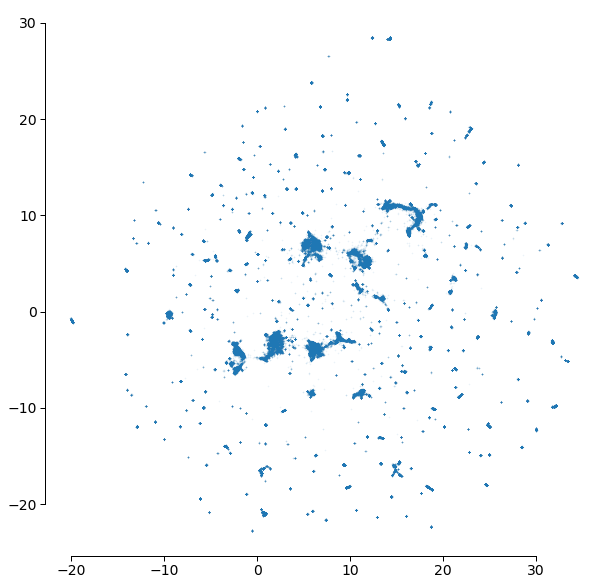

In [3]:
plt.scatter(*out_angs.T, s=1, alpha=0.05)
sns.despine(trim=True)


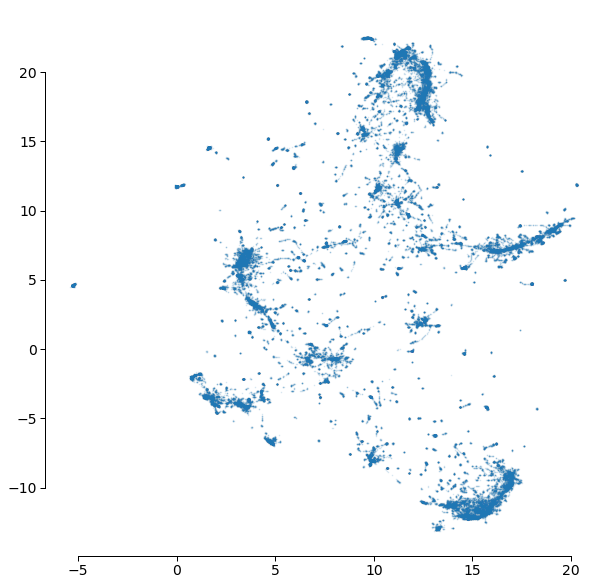

In [4]:
plt.scatter(*out_wavs.T, s=1, alpha=0.1)
sns.despine(trim=True)


In [4]:
# min_cluster_size = 1000
# min_cluster_size = 1500
# min_cluster_size = 1750
min_cluster_size = 2000
# alpha = 0.1 # no hace nada este parametro!
# cluster_selection_epsilon = 1.0 # Breaks soft cluster and approximate prediction, leave as deafult
point_size = 1
point_alpha = 0.1

In [17]:
clu_wavs = hdbscan.HDBSCAN(
  min_cluster_size=min_cluster_size,
  # core_dist_n_jobs=-1,
  prediction_data=True # To allow soft clustering (mixed membership)
).fit(out_wavs)

In [18]:
cluster_labels = clu_wavs.labels_
num_clusters = cluster_labels.max() + 1
cluster_probabilities = clu_wavs.probabilities_
color_palette = sns.color_palette("hls", num_clusters)
cluster_colors = [
  color_palette[x] if x >= 0
  else (0.5, 0.5, 0.5)
  for x in cluster_labels
]
cluster_member_colors = [
  sns.desaturate(x, p) for x, p in
  zip(cluster_colors, cluster_probabilities)
]
print(num_clusters, "clusters")
fraction_noise = (cluster_labels == -1).sum() / len(cluster_labels)
print(f"{fraction_noise:.2f} noise")

6 clusters
0.17 noise


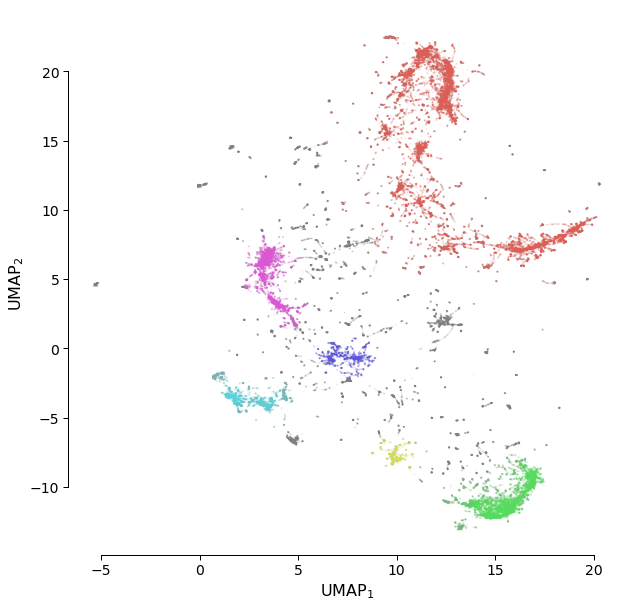

In [19]:
plt.scatter(
    *out_wavs.T,
    s=point_size, c=cluster_member_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

/home/alvaro/.local/lib/python3.8/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


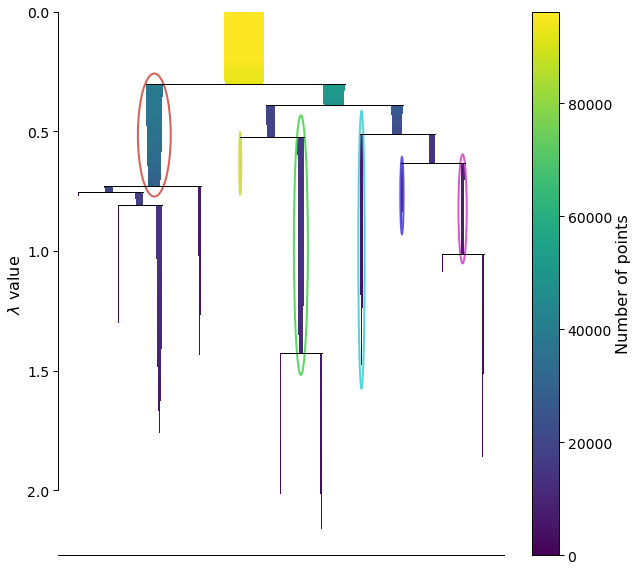

In [20]:
clu_wavs.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("hls", num_clusters)
)
sns.despine(trim=True)
plt.show()

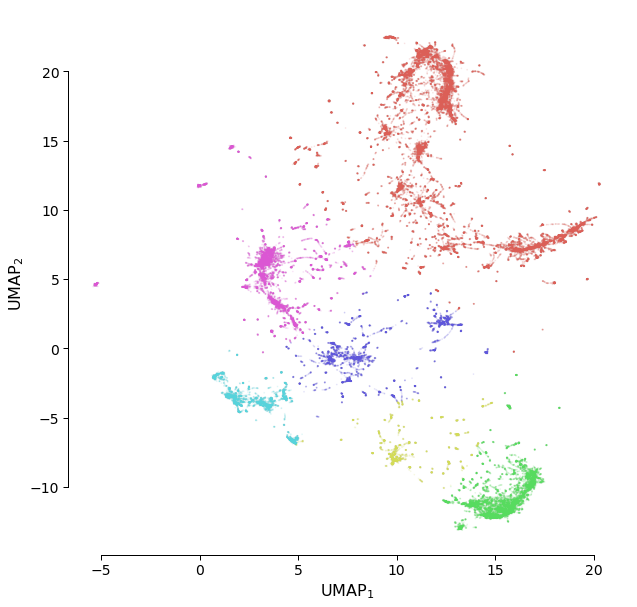

In [21]:
soft_clusters = hdbscan.all_points_membership_vectors(clu_wavs)
cluster_colors = [
    color_palette[np.argmax(x)]
    for x in soft_clusters
]
plt.scatter(
    *out_wavs.T,
    s=point_size, c=cluster_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

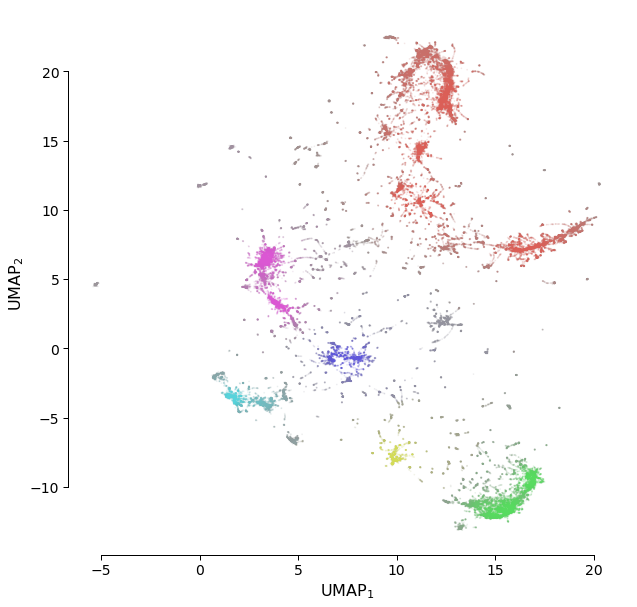

In [22]:
cluster_colors = [
    sns.desaturate(color_palette[np.argmax(x)], np.max(x))
    for x in soft_clusters
]
plt.scatter(
    *out_wavs.T,
    s=point_size, c=cluster_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

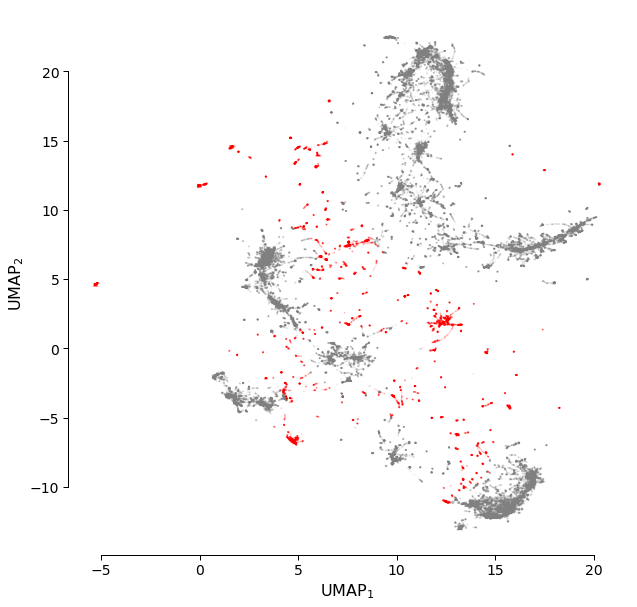

In [23]:
def top_two_probs_diff(probs):
    sorted_probs = np.sort(probs)
    return sorted_probs[-1] - sorted_probs[-2]

# Compute the differences between the top two probabilities
diffs = np.array([top_two_probs_diff(x) for x in soft_clusters])
# Select out the indices that have a small difference, and a larger total probability
mixed_points = np.where(
    # (diffs < 0.1) & (np.sum(soft_clusters, axis=1) > 0.5)
    (diffs < 0.1) & (np.sum(soft_clusters, axis=1) > 0.1)
)[0]

colors = [
    (1., 0., 0.) if x in mixed_points
    else (0.5, 0.5, 0.5) for x in range(out_wavs.shape[0])
]
plt.scatter(
    *out_wavs.T,
    s=point_size, c=colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

Cluster #0 has 8000 exemplars
Cluster #1 has 2000 exemplars
Cluster #2 has 4000 exemplars
Cluster #3 has 2000 exemplars
Cluster #4 has 2000 exemplars
Cluster #5 has 4000 exemplars


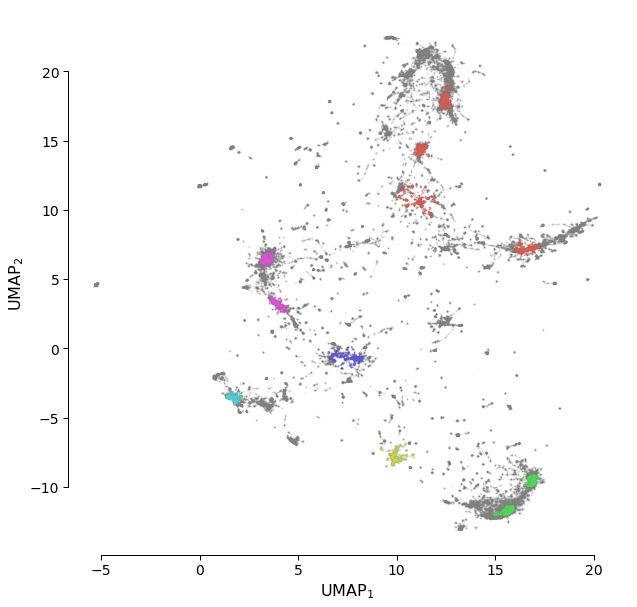

In [24]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) &
            (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

color_palette = sns.color_palette("hls", num_clusters)
tree = clu_wavs.condensed_tree_
plt.scatter(
    *out_wavs.T,
    color="grey", s=point_size, alpha=point_alpha)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(
        *out_wavs.T[:, c_exemplars],
        color=color_palette[i], s=point_size, alpha=point_alpha
    )
    print(f"Cluster #{i} has {len(c_exemplars)} exemplars")
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

In [2]:
mask_main = np.logical_and.reduce(
    (out_angs[:, 0] <= 20,
    out_angs[:, 0] >= -5,
    out_angs[:, 1] <= 15,
    out_angs[:, 1] >= -10)
)
out_angs_main = out_angs[mask_main]

In [3]:
len(out_angs_main)

177534

In [4]:
min_cluster_size = 2000
point_size = 1
point_alpha = 0.1

clu_angs = hdbscan.HDBSCAN(
  min_cluster_size=min_cluster_size,
  # core_dist_n_jobs=-1,
  prediction_data=True # To allow soft clustering (mixed membership)
# ).fit(out_angs[::3])
).fit(out_angs_main[::2])

In [5]:
cluster_labels = clu_angs.labels_
num_clusters = cluster_labels.max() + 1
cluster_probabilities = clu_angs.probabilities_
color_palette = sns.color_palette("hls", num_clusters)
cluster_colors = [
  color_palette[x] if x >= 0
  else (0.5, 0.5, 0.5)
  for x in cluster_labels
]
cluster_member_colors = [
  sns.desaturate(x, p) for x, p in
  zip(cluster_colors, cluster_probabilities)
]
print(num_clusters, "clusters")
fraction_noise = (cluster_labels == -1).sum() / len(cluster_labels)
print(f"{fraction_noise:.2f} noise")

9 clusters
0.17 noise


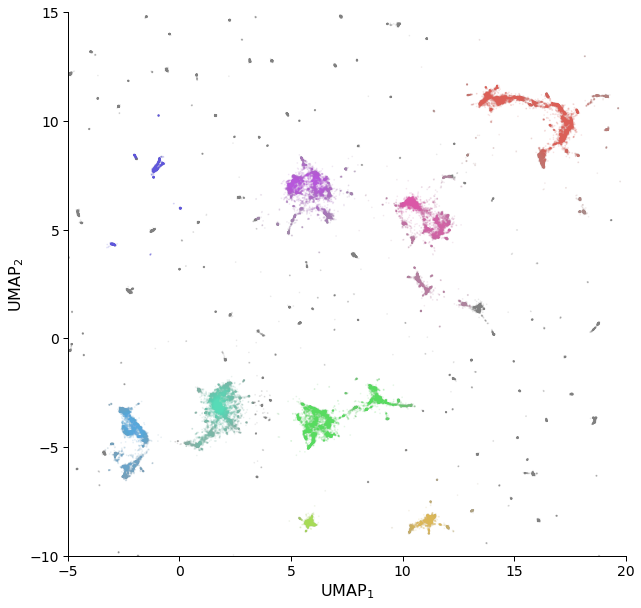

In [6]:
plt.scatter(
    # *out_angs[::3].T,
    *out_angs_main[::2].T,
    s=point_size, c=cluster_member_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
# plt.xlim(-5, 20)
# plt.ylim(-10, 15)
sns.despine(trim=True)
plt.show()

/home/alvaro/.local/lib/python3.8/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


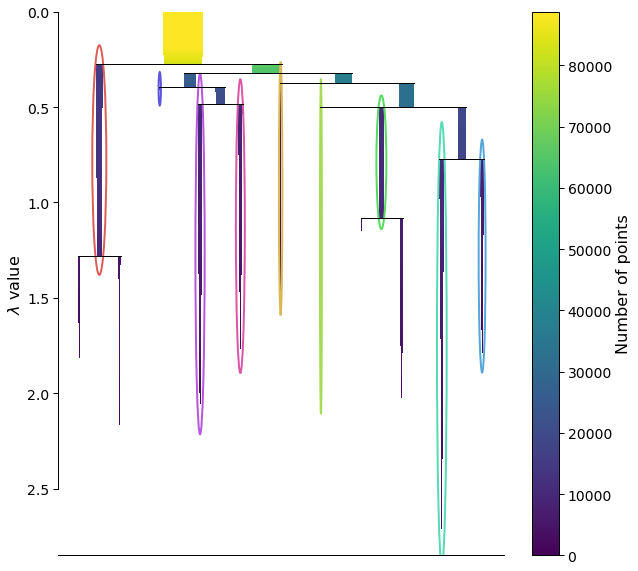

In [7]:
clu_angs.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("hls", num_clusters)
)
sns.despine(trim=True)
plt.show()

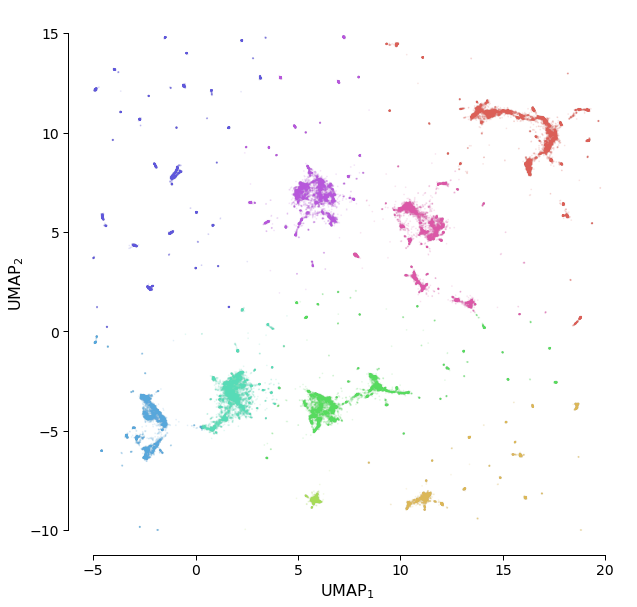

In [8]:
soft_clusters = hdbscan.all_points_membership_vectors(clu_angs)
cluster_colors = [
    color_palette[np.argmax(x)]
    for x in soft_clusters
]
plt.scatter(
    # *out_angs[::3].T,
    *out_angs_main[::2].T,
    s=point_size, c=cluster_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

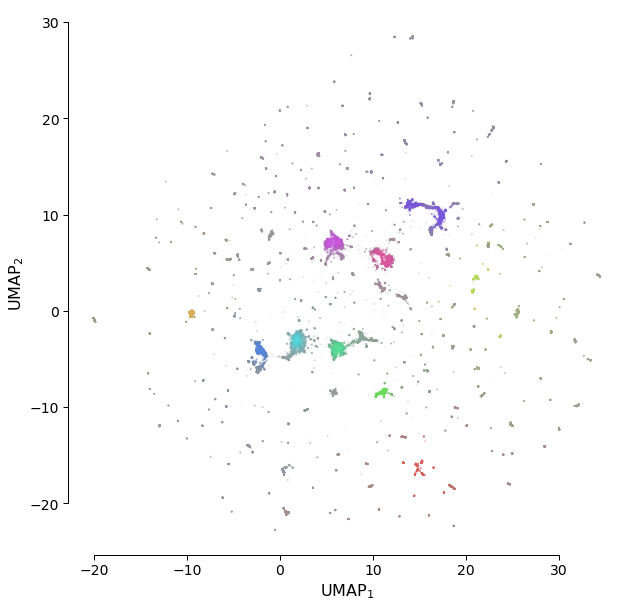

In [8]:
cluster_colors = [
    sns.desaturate(color_palette[np.argmax(x)], np.max(x))
    for x in soft_clusters
]
plt.scatter(
    *out_angs[::3].T,
    s=point_size, c=cluster_colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

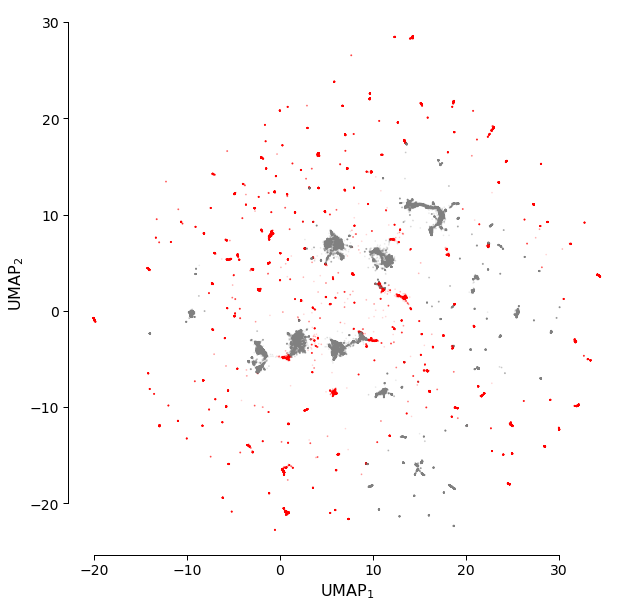

In [9]:
def top_two_probs_diff(probs):
    sorted_probs = np.sort(probs)
    return sorted_probs[-1] - sorted_probs[-2]

# Compute the differences between the top two probabilities
diffs = np.array([top_two_probs_diff(x) for x in soft_clusters])
# Select out the indices that have a small difference, and a larger total probability
mixed_points = np.where(
    # (diffs < 0.1) & (np.sum(soft_clusters, axis=1) > 0.5)
    (diffs < 0.1) & (np.sum(soft_clusters, axis=1) > 0.1)
)[0]

colors = [
    (1., 0., 0.) if x in mixed_points
    else (0.5, 0.5, 0.5) for x in range(out_angs[::3].shape[0])
]
plt.scatter(
    *out_angs[::3].T,
    s=point_size, c=colors, alpha=point_alpha
)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()

Cluster #0 has 2000 exemplars
Cluster #1 has 2000 exemplars
Cluster #2 has 2000 exemplars
Cluster #3 has 2000 exemplars
Cluster #4 has 2000 exemplars
Cluster #5 has 2000 exemplars
Cluster #6 has 2000 exemplars
Cluster #7 has 4000 exemplars
Cluster #8 has 2000 exemplars
Cluster #9 has 2000 exemplars


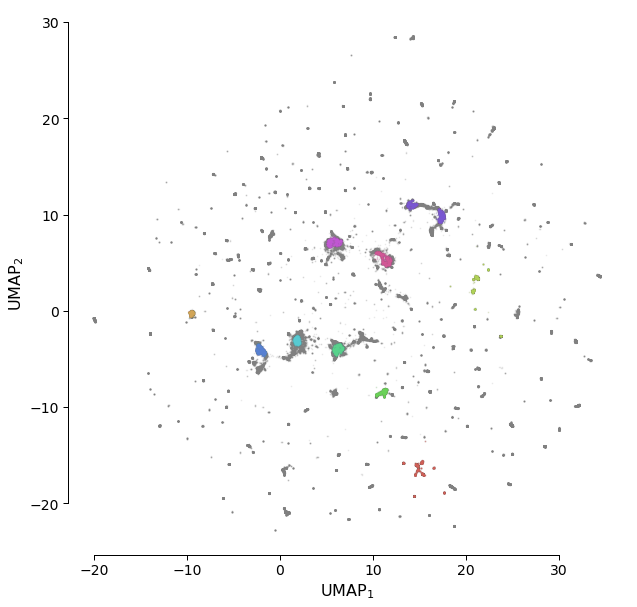

In [10]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) &
            (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

color_palette = sns.color_palette("hls", num_clusters)
tree = clu_angs.condensed_tree_
plt.scatter(
    *out_angs[::3].T,
    color="grey", s=point_size, alpha=point_alpha)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(
        *out_angs[::3].T[:, c_exemplars],
        color=color_palette[i], s=point_size, alpha=point_alpha
    )
    print(f"Cluster #{i} has {len(c_exemplars)} exemplars")
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.show()